In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
!nvidia-smi

Sun Mar  9 20:21:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.04             Driver Version: 570.124.04     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5000               Off |   00000000:01:00.0 Off |                  Off |
| 30%   36C    P8             29W /  230W |     152MiB /  24564MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## T5 fine-tuning

This notebook is to showcase how to fine-tune [T5 model](https://arxiv.org/abs/1910.10683) with Huggigface's [Transformers](https://github.com/huggingface/transformers/) to solve different NLP tasks using text-2-text approach proposed in the T5 paper. For demo I chose 3 non text-2-text problems just to reiterate the fact from the paper that how widely applicable this text-2-text framework is and how it can be used for different tasks without changing the model at all.



In [3]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation
from functools import partial

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger

# torch.set_float32_matmul_precision('medium')  # or 'high'

from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

[nltk_data] Downloading package punkt to
[nltk_data]     /users/eleves-b/2022/mathias.perez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/users/eleves-b/2022/mathias.perez/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(42)

## Model

We'll be using the awesome [pytorch-lightning](https://github.com/PytorchLightning/pytorch-lightning) library for training. Most of the below code is adapted from here https://github.com/huggingface/transformers/blob/master/examples/lightning_base.py

The trainer is generic and can be used for any text-2-text task. You'll just need to change the dataset. Rest of the code will stay unchanged for all the tasks.

This is the most intresting and powrfull thing about the text-2-text format. You can fine-tune the model on variety of NLP tasks by just formulating the problem in text-2-text setting. No need to change hyperparameters, learning rate, optimizer or loss function. Just plug in your dataset and you are ready to go!

In [5]:
# Util Function used for Dynamic Padding in DataLoader

def dynamic_collate_fn(batch, tokenizer):
    """
    Pads a batch of examples dynamically using the tokenizer's pad() method.
    Assumes that each item in batch is a dict with keys: input_ids, attention_mask, target_ids, target_mask.
    """
    # Extract lists of all sequences
    input_ids = [item["source_ids"] for item in batch]
    attention_masks = [item["source_mask"] for item in batch]
    target_ids = [item["target_ids"] for item in batch]
    target_masks = [item["target_mask"] for item in batch]
    
    # Use the tokenizer's pad method to dynamically pad the sequences in the batch.
    padded_inputs = tokenizer.pad({"input_ids": input_ids, "attention_mask": attention_masks}, return_tensors="pt")
    padded_targets = tokenizer.pad({"input_ids": target_ids, "attention_mask": target_masks}, return_tensors="pt")
    
    return {
        "source_ids": padded_inputs["input_ids"],
        "source_mask": padded_inputs["attention_mask"],
        "target_ids": padded_targets["input_ids"],
        "target_mask": padded_targets["attention_mask"]
    }

In [6]:
class T5FineTuner(pl.LightningModule):
  def __init__(self, hparams):
    super(T5FineTuner, self).__init__()
    self.save_hyperparameters(hparams)

    self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path, cache_dir="/users/eleves-b/2022/mathias.perez/Desktop/JuridixAssistant/models_cache")
    self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path, cache_dir="/users/eleves-b/2022/mathias.perez/Desktop/JuridixAssistant/models_cache")
    
    self.train_losses = []

  def is_logger(self):
    return self.trainer.global_rank == 0

  def forward(self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, labels=None):
    return self.model(
        input_ids,
        attention_mask=attention_mask,
        decoder_input_ids=decoder_input_ids,
        decoder_attention_mask=decoder_attention_mask,
        labels=labels,  # pass labels
    )
  
  def _step(self, batch):
    labels = batch["target_ids"].clone()
    # Replace pad token ids with -100 to ignore them in the loss calculation
    labels[labels == self.tokenizer.pad_token_id] = -100

    outputs = self(
        input_ids=batch["source_ids"],
        attention_mask=batch["source_mask"],
        labels=labels,  # use 'labels' here instead of 'lm_labels'
        decoder_attention_mask=batch["target_mask"]
    )
    loss = outputs.loss  # or outputs[0] if you prefer that indexing
    return loss

  def training_step(self, batch, batch_idx):
    loss = self._step(batch)
    self.train_losses.append(loss)
    self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return {"loss": loss}

  # def on_train_epoch_end(self):
  #   # Example: Log the average training loss for the epoch.
  #   avg_train_loss = torch.stack(self.train_losses).mean() if self.train_losses else 0.0
  #   self.log("avg_train_loss", avg_train_loss)
  #   # Clear the list for the next epoch.
  #   self.train_losses.clear()

  def validation_step(self, batch, batch_idx):
    loss = self._step(batch)
    self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return {"val_loss": loss}

  def configure_optimizers(self):
    "Prepare optimizer and schedule (linear warmup and decay)"

    model = self.model
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": self.hparams.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
    self.opt = optimizer
    return [optimizer]
    
  # def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, optimizer_closure=None, **kwargs):
  #   # Call the closure as required by Lightning.
  #   optimizer.step(closure=optimizer_closure)
  #   optimizer.zero_grad()
  #   self.lr_scheduler.step()

  def get_tqdm_dict(self):
    tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

    return tqdm_dict

  def train_dataloader(self):
    train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", args=self.hparams)
    dataloader = DataLoader(
        train_dataset,
        batch_size=self.hparams.train_batch_size,
        drop_last=True,
        shuffle=True,
        num_workers=2,
        collate_fn=partial(dynamic_collate_fn, tokenizer=self.tokenizer)
    )
    t_total = (
        (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
        // self.hparams.gradient_accumulation_steps
        * float(self.hparams.num_train_epochs)
    )
    scheduler = get_linear_schedule_with_warmup(
        self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
    )
    self.lr_scheduler = scheduler
    return dataloader

  def val_dataloader(self):
    val_dataset = get_dataset(tokenizer=self.tokenizer, type_path="val", args=self.hparams)
    return DataLoader(
        val_dataset,
        batch_size=self.hparams.eval_batch_size,
        num_workers=2,
        collate_fn=partial(dynamic_collate_fn, tokenizer=self.tokenizer)
    )

In [7]:
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
  def on_validation_end(self, trainer, pl_module):
    logger.info("***** Validation results *****")
    if pl_module.is_logger():
      metrics = trainer.callback_metrics
      # Log results
      for key in sorted(metrics):
        if key not in ["log", "progress_bar"]:
          logger.info("{} = {}\n".format(key, str(metrics[key])))

  def on_test_end(self, trainer, pl_module):
    logger.info("***** Test results *****")

    if pl_module.is_logger():
      metrics = trainer.callback_metrics

      # Log and save results to file
      output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
      with open(output_test_results_file, "w") as writer:
        for key in sorted(metrics):
          if key not in ["log", "progress_bar"]:
            logger.info("{} = {}\n".format(key, str(metrics[key])))
            writer.write("{} = {}\n".format(key, str(metrics[key])))

Let's define the hyperparameters and other arguments. You can overide this `dict` for specific task as needed. While in most of cases you'll only need to change the `data_dir`and `output_dir`.

Here the batch size is 8 and gradient_accumulation_steps are 16 so the effective batch size is 128

In [8]:
args_dict = dict(
    data_dir="", # path for data files
    output_dir="/users/eleves-b/2022/mathias.perez/Desktop/JuridixAssistant/data/Juridix/saved_models/ft_T5", # path to save the checkpoints
    model_name_or_path='t5-large',
    tokenizer_name_or_path='t5-large',
    max_seq_length=512,
    learning_rate=3e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=8,
    eval_batch_size=4,
    num_train_epochs=3,
    gradient_accumulation_steps=16,
    n_gpu=1,
    early_stop_callback=False,
    fp_16=False, # if you want to enable 16-bit training then install apex and set this to true
    opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=1.0, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=42,
)

## Generation (or Loading of Dataset)

### Format of the Data :

The dataset should be carefully curated and annotated to support two key objectives: first, to classify the type of document referenced in a given query, and second, to generate an improved, reformulated version of the query. 

Each sample in the dataset must consist of a raw query, a corresponding document type label, and a high-quality, rewritten query that maintains the original intent while enhancing clarity and precision. 

The document types include labels such as PUA, Promesse, and Cession, as well as more nuanced categories like Protocole (PROTO), Bails (either general or with specific details), Garantie (Gap), Acte réitératif (réitératif), Pacte (d'associé), and Transaction (transactionnel, including related forms like protocole transactionnel or transac).

Below is a detailed list of the document categories along with example lowercase regex patterns for each. 
These patterns are designed to match the specific keywords in a case-insensitive context (assuming the text is converted to lowercase before matching):

- PUA
Regex: \bpua\b

- Promesse
Regex: \bpromesse\b

- Cession
Regex: \bcession\b

- Protocole (proto)
Regex: \bprotocole\b|\bproto\b

- Bails
Regex: \bbail(s)?\b => (This pattern matches both the singular "bail" and the plural "bails".)

- Garantie (gap)
Regex: \bgarantie\b|\bgap\b

- Acte réitératif (réitératif)
Regex: \bacte réitératif\b|\bréitératif\b

- Pacte
Regex: \bpacte\b

- Transaction / transactionnel
Regex: \btransaction(?:nel)?\b|\btransac\b =>(This pattern covers both "transaction" and its adjectival form "transactionnel", as well as a shorthand "transac".)

Below is an example of how each data sample in your dataset might be structured. In this JSON-like format, the input field contains the original query text, while the output field is an object that holds both the classified document type and the improved, reformulated query:

{
  "input": "I need the contract details for the promise regarding the asset transfer",
  "output": {
    "type": "promesse",
    "reformulated_query": "Provide the contractual details for the asset transfer promise"
  }
}

#### Load Dataset and prepare training and Validation sets 

### Prepare Dataset

In [9]:
tokenizer = T5Tokenizer.from_pretrained('t5-large', cache_dir="/users/eleves-b/2022/mathias.perez/Desktop/JuridixAssistant/models_cache")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


The dataset below takes care of reading the review files and processing the examples in text-2-text format.

It cleans the review text by removing the html tags. It also appends the eos token `</s>` at the end of input and target as required by the T5 model

For T5 max input length is 512 and we can choose the max length for target sequence depending upon our dataset. The `T5Tokenizer` encodes both 'postive' and 'negative' as a single ids so I chose the max target length 2, extra 1 for the `</s>` token

In [10]:
class QueryDataset(Dataset):
    def __init__(self, tokenizer, csv_file, max_len=512, target_max_len=128):
        """
        Initializes the dataset.
        
        Args:
          tokenizer: Tokenizer to convert text to input IDs.
          csv_file: Path to the CSV file containing the data.
          max_len: Maximum length for tokenizing the input query.
          target_max_len: Maximum length for tokenizing the target output.
        """
        self.tokenizer = tokenizer
        self.data = pd.read_csv(csv_file)
        self.max_len = max_len
        self.target_max_len = target_max_len
        self.inputs = []
        self.targets = []
        self._build()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        source_ids = self.inputs[index]["input_ids"].squeeze()
        target_ids = self.targets[index]["input_ids"].squeeze()
        src_mask = self.inputs[index]["attention_mask"].squeeze()
        target_mask = self.targets[index]["attention_mask"].squeeze()

        return {
            "source_ids": source_ids,
            "source_mask": src_mask,
            "target_ids": target_ids,
            "target_mask": target_mask
        }

    def _build(self):
        for _, row in self.data.iterrows():
            # Extract the initial query and target components.
            initial_query = row['initial_query'].strip()
            doc_type = row['type'].strip()
            new_query = row['new_query'].strip()
            
            # Construct the target string.
            # Example format: "promesse : Provide the contractual details..."
            target = f"Type: {doc_type} ; Reformulation: {new_query} </s>"
            
            # Append a termination token to the input query.
            prefix = "Classifie SEULEMENT avec les types suivants : [acte réitératif, bails, cession, garantie, pacte, promesse, protocole, pua, transaction] et reformule la demande suivante: "
            input_text = initial_query + " </s>"
            
            input_text = prefix + input_text
            
            # Tokenize input text.
            tokenized_inputs = self.tokenizer.batch_encode_plus(
                [input_text],
                max_length=self.max_len,
                truncation=True, 
                padding=False, # Could be changed to 'max_length' if necessary.
                return_tensors="pt"
            )
            
            # Tokenize target text.
            tokenized_targets = self.tokenizer.batch_encode_plus(
                [target],
                max_length=self.target_max_len,
                truncation=True,
                padding=False, # Could be changed to 'max_length' if necessary.
                return_tensors="pt"
            )
            
            self.inputs.append(tokenized_inputs)
            self.targets.append(tokenized_targets)

In [11]:
# Create Dataset
path_to_csv = "train_dataset.csv"
dataset = QueryDataset(tokenizer, path_to_csv, max_len=512, target_max_len=128)
len(dataset)

/users/eleves-b/2022/mathias.perez/.local/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5.py:289: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


4332

In [12]:
data = dataset[28]
print(tokenizer.decode(data['source_ids']))
print(tokenizer.decode(data['target_ids']))

Classifie SEULEMENT avec les types suivants : [acte réitératif, bails, cession, garantie, pacte, promesse, protocole, pua, transaction] et reformule la demande suivante: Bonjour, est-ce que vous avement déjà lu et compris la réglementation sur les actes réitératifs lors d'une vente immobilière ?</s>
Type: acte réitératif ; Reformulation: La réglementation sur les actes réitératifs lors d'une vente immobilière est-elle comprise et lue ?</s>


### Train

In [13]:
args_dict.update({'path_to_csv': '_dataset.csv'})
args = argparse.Namespace(**args_dict)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=args.output_dir,
    filename="checkpoint-{epoch:02d}-{val_loss:.2f}",
    monitor="val_loss",
    mode="min",
    save_top_k=1,
)

# Create a TensorBoard logger
model_name = "ft_T5_prompt_engineered"
csv_logger = CSVLogger("csv_logs", name=model_name)

train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    accelerator="gpu",       # Use GPU accelerator
    devices=args.n_gpu,        # Number of GPUs to use
    max_epochs=args.num_train_epochs,
    precision=16 if args.fp_16 else 32,
    gradient_clip_val=args.max_grad_norm,
    callbacks=[checkpoint_callback, LoggingCallback()],
    logger=csv_logger,  # Pass the TensorBoard logger here
)

Define the `get_dataset` function to return the dataset. The model calls this function to get the train and val datasets. We are defining a dataset function so that we won't need to modify the model code at all. Redefine the function to return different dataset according to the problem. While this is not the best solution for now this works

In [14]:
def get_dataset(tokenizer, type_path, args):
  if type_path in ['train', 'val', 'test']:
    path_to_csv = type_path + args.path_to_csv
    return QueryDataset(tokenizer=tokenizer, csv_file=path_to_csv, max_len=args.max_seq_length)
  else:
    raise ValueError(f'{type_path} not supported')

**Initialize model**

In [15]:
model = T5FineTuner(args)

**Initialize trainer**

In [16]:
trainer = pl.Trainer(**train_params)

/users/eleves-b/2022/mathias.perez/.local/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /users/eleves-b/2022/mathias.perez/.local/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


**start fine-tuning**

In [17]:
trainer.fit(model)
# trainer.fit(model, ckpt_path="path/to/checkpoint.ckpt")

You are using a CUDA device ('NVIDIA RTX A5000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/users/eleves-b/2022/mathias.perez/.local/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Data/mathias.p/Juridix/saved_models/ft_T5 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/users/eleves-b/2022/mathias.perez/.local/lib/python3.9/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name  | Type                       | Params |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/users/eleves-b/2022/mathias.perez/.local/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5.py:289: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


/users/eleves-b/2022/mathias.perez/.local/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5.py:289: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


Epoch 2: 100%|██████████| 541/541 [02:54<00:00,  3.10it/s, v_num=2, train_loss_step=0.149, val_loss_step=0.948, val_loss_epoch=0.358, train_loss_epoch=0.162] 

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 541/541 [02:54<00:00,  3.10it/s, v_num=2, train_loss_step=0.149, val_loss_step=0.948, val_loss_epoch=0.358, train_loss_epoch=0.162]


In [18]:
## save the model this way so next time you can load it using T5ForConditionalGeneration.from_pretrained
model.model.save_pretrained('/users/eleves-b/2022/mathias.perez/Desktop/JuridixAssistant/data/Juridix/saved_models/ft_T5/v5_3ep_promptE_strong')

   epoch  step  train_loss_epoch  train_loss_step  val_loss_epoch  \
0    NaN     0               NaN              NaN             NaN   
1    NaN     1               NaN              NaN             NaN   
2    NaN     2               NaN              NaN             NaN   
3    NaN     3               NaN              NaN             NaN   
4    NaN     4               NaN              NaN             NaN   

   val_loss_step  
0       0.267523  
1       0.256238  
2       0.307827  
3       0.198209  
4       0.185060  


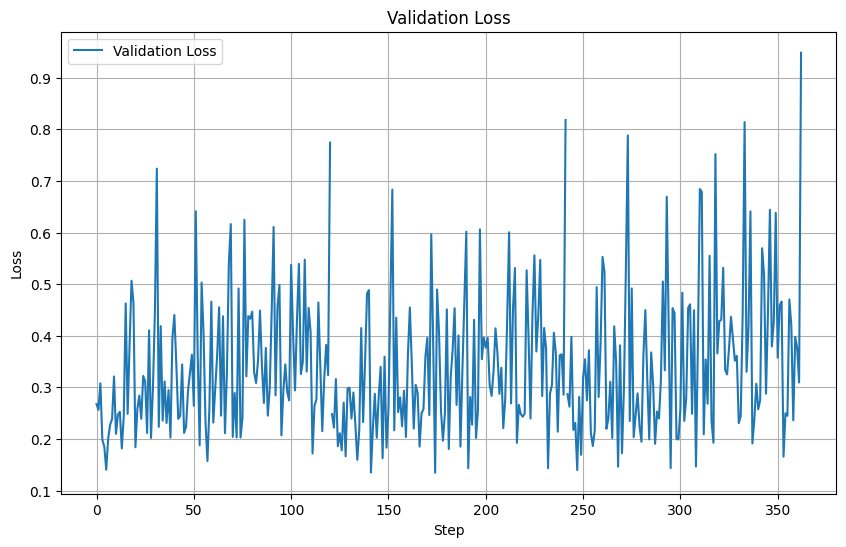

In [19]:
# Path to your CSV metrics file (update this path as needed)
metrics_file = f"csv_logs/{model_name}/version_2/metrics.csv"

# Load the metrics CSV into a DataFrame
df = pd.read_csv(metrics_file)

# Display the DataFrame to see its contents
print(df.head())

# Plot training and validation loss over epochs (assuming columns 'train_loss' and 'val_loss' exist)
plt.figure(figsize=(10, 6))
if "val_loss_step" in df.columns:
    plt.plot(df["step"], df["val_loss_step"], label="Validation Loss")

plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


### Eval

For inference we will use the `generate` method with greedy decoding with max length 2.

In [20]:
import textwrap
from tqdm.auto import tqdm
from sklearn import metrics

Let's visualize few predictions on test dataset

In [21]:
path_to_test_csv = "test_dataset.csv"
dataset = QueryDataset(tokenizer, csv_file=path_to_test_csv,  max_len=512)
loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=partial(dynamic_collate_fn, tokenizer=tokenizer))

/users/eleves-b/2022/mathias.perez/.local/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5.py:289: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


In [22]:
it = iter(loader)

In [23]:
batch = next(it)
batch["source_ids"].shape

torch.Size([32, 137])

In [24]:
model.model.to("cuda")
outs = model.model.generate(input_ids=batch['source_ids'].cuda(),
                              attention_mask=batch['source_mask'].cuda(),
                              max_length=128)

dec = [tokenizer.decode(ids, skip_special_tokens=True) for ids in outs]

texts = [tokenizer.decode(ids) for ids in batch['source_ids']]
targets = [tokenizer.decode(ids) for ids in batch['target_ids']]

In [25]:
for i in range(32):
    lines = textwrap.wrap("Initial Query:\n%s\n" % texts[i], width=100)
    print("\n".join(lines))
    print("\nActual classification and rewriting: %s" % targets[i])
    print("Predicted classification and rewriting: %s" % dec[i])
    print("=====================================================================\n")

Initial Query: Classifie SEULEMENT avec les types suivants : [acte réitératif, bails, cession,
garantie, pacte, promesse, protocole, pua, transaction] et reformule la demande suivante: Bonjour,
je cherche des informations sur le contrat de mariage. Peut-être connais-tu une source confiable
pour ce type de document?</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><
pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><
pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

Actual classification and rewriting: Type: pacte ; Reformulation: Quels sont les termes et conditions du contrat de mariage en France?</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
Predicted classification and rewriting: Type: pacte ; Reformulation: Quelles sont les sources de renseignements sur le contrat de mariage en France?

Initial Query: Classifie SEULEME

Now predict on all the test dataset

In [26]:
def extract_fields(text):
    """
    Extracts document type and new_query from a formatted string.
    Assumes the text is in the format:
      "type: {doc_type} ; new_query: {new_query}"
      
    Returns:
      A tuple (doc_type, new_query) if both fields are found,
      otherwise (None, None).
    """
    # Updated regex:
    # Group 1: Everything after "type:" until the semicolon (allows spaces)
    # Group 2: Everything after "new_query:" until the end.
    pattern = r"^type:\s*([^;]+?)\s*;\s*reformulation:\s*(.+)$"
    match = re.match(pattern, text.lower().strip())
    if match:
        doc_type = match.group(1).strip()
        new_query = match.group(2).strip()
        return doc_type, new_query
    return None, None


In [27]:
loader = DataLoader(dataset, batch_size=32, num_workers=4, collate_fn=partial(dynamic_collate_fn, tokenizer=tokenizer))
model.model.eval()
outputs = []
targets = []
raw_inputs = []

for batch in tqdm(loader):
    # Ensure tensors are on the same device.
    source_ids = batch['source_ids'].to("cuda")
    source_mask = batch['source_mask'].to("cuda")
    
    # Generate outputs.
    outs = model.model.generate(
        input_ids=source_ids,
        attention_mask=source_mask,
        max_length=128  # Adjust if necessary.
    )
    
    # Decode predictions, targets, and raw input texts.
    dec = [tokenizer.decode(ids, skip_special_tokens=True) for ids in outs]
    batch_targets = [tokenizer.decode(ids, skip_special_tokens=True) for ids in batch["target_ids"]]
    batch_inputs = [tokenizer.decode(ids, skip_special_tokens=True) for ids in batch["source_ids"]]
    
    outputs.extend(dec)
    targets.extend(batch_targets)
    raw_inputs.extend(batch_inputs)

100%|██████████| 17/17 [00:44<00:00,  2.60s/it]


Let's check if the model generates valid predictions

In [28]:
# Check for valid formatted outputs and count invalid entries.
print("Checking for valid formatted outputs...\n")
invalid_pred_count = 0
invalid_target_count = 0
total = len(outputs)  # assuming outputs and targets have the same length

for i, (pred_text, tgt_text) in enumerate(zip(outputs, targets)):
    pred_type, pred_new_query = extract_fields(pred_text)
    tgt_type, tgt_new_query = extract_fields(tgt_text)
    
    if pred_type is None or pred_new_query is None:
        print(f"Index {i}: Invalid prediction format: '{pred_text}'")
        invalid_pred_count += 1
    if tgt_type is None or tgt_new_query is None:
        print(f"Index {i}: Invalid target format: '{tgt_text}'")
        invalid_target_count += 1

print(f"\nInvalid predictions: {invalid_pred_count} out of {total} ({(invalid_pred_count/total)*100:.2f}%)")
print(f"Invalid targets: {invalid_target_count} out of {total} ({(invalid_target_count/total)*100:.2f}%)")


Checking for valid formatted outputs...


Invalid predictions: 0 out of 535 (0.00%)
Invalid targets: 0 out of 535 (0.00%)


This great is great! Our model hasn't generated any invalid prediction. Let's calculate accuarcy and other metrics

In [29]:
# Initialize overall counters.
correct_classification = 0
total_samples = 0

for raw_input, pred_text, tgt_text in zip(raw_inputs, outputs, targets):
    pred_type, _ = extract_fields(pred_text)
    tgt_type, _ = extract_fields(tgt_text)
    
    # Skip if extraction fails.
    if pred_type is None or tgt_type is None:
        continue
    
    total_samples += 1
    if pred_type == tgt_type:
        correct_classification += 1
    else:
        print("Original Input:")
        print(raw_input)
        print(f"Predicted: {pred_type} | Target: {tgt_type} | Incorrect")
        print("=====================================================================\n")

overall_accuracy = correct_classification / total_samples * 100
print(f"Overall Classification Accuracy: {overall_accuracy:.2f}%")

Original Input:
Classifie SEULEMENT avec les types suivants : [acte réitératif, bails, cession, garantie, pacte, promesse, protocole, pua, transaction] et reformule la demande suivante: Est-ce que vous pouvez me prévenir lorsque mon contrat aura besoin d'un renouvellement?
Predicted: pua | Target: acte réitératif | Incorrect

Original Input:
Classifie SEULEMENT avec les types suivants : [acte réitératif, bails, cession, garantie, pacte, promesse, protocole, pua, transaction] et reformule la demande suivante: Bonjour, est-ce que vous pouvez me confirmer si j'ai bien compris le contrat de travail précédemment signé? Merci de m'aider à le vérifier.
Predicted: pacte | Target: acte réitératif | Incorrect

Original Input:
Classifie SEULEMENT avec les types suivants : [acte réitératif, bails, cession, garantie, pacte, promesse, protocole, pua, transaction] et reformule la demande suivante: Bonjour, Je suis ici pour obtenir plus d'informations sur la possibilité de louer un bureau dans ma bout

This cell computes the accuracy for each document category separately.

In [30]:
from collections import defaultdict

# Initialize per-category counters.
per_category_correct = defaultdict(int)
per_category_total = defaultdict(int)

for pred_text, tgt_text in zip(outputs, targets):
    pred_type, _ = extract_fields(pred_text)
    tgt_type, _ = extract_fields(tgt_text)
    
    # Skip if extraction failed.
    if pred_type is None or tgt_type is None:
        continue
    
    per_category_total[tgt_type] += 1
    if pred_type == tgt_type:
        per_category_correct[tgt_type] += 1

print("Per-Category Accuracy:")
for doc_type in per_category_total:
    cat_accuracy = per_category_correct[doc_type] / per_category_total[doc_type] * 100
    print(f"  {doc_type}: {cat_accuracy:.2f}% ({per_category_correct[doc_type]}/{per_category_total[doc_type]})")


Per-Category Accuracy:
  acte réitératif: 96.67% (58/60)
  bails: 98.21% (55/56)
  cession: 100.00% (60/60)
  garantie: 100.00% (64/64)
  pacte: 91.53% (54/59)
  promesse: 100.00% (59/59)
  protocole: 98.36% (60/61)
  pua: 100.00% (60/60)
  transaction: 87.50% (49/56)


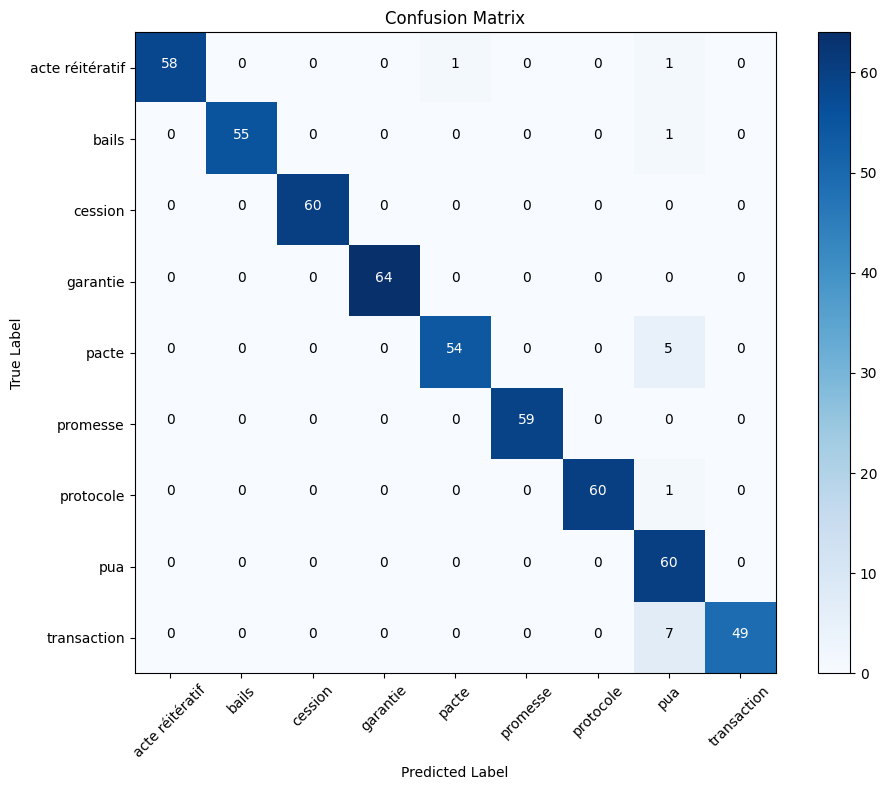

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Extract true and predicted document types from the outputs.
true_labels = []
pred_labels = []
for pred_text, tgt_text in zip(outputs, targets):
    pred_type, _ = extract_fields(pred_text)
    tgt_type, _ = extract_fields(tgt_text)
    if pred_type is None or tgt_type is None:
        continue  # Skip entries with invalid formatting.
    true_labels.append(tgt_type)
    pred_labels.append(pred_type)

# Get the sorted list of unique classes.
classes = sorted(list(set(true_labels + pred_labels)))

# Compute the confusion matrix.
cm = confusion_matrix(true_labels, pred_labels, labels=classes)

# Plot the confusion matrix.
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add text annotations inside each cell.
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()